## LEVERAGING DATA-DRIVEN INSIGHTS FOR E-COMMERCE GROWTH

### Introduction
In the highly competitive e-commerce landscape, optimizing business performance through data-driven insights is paramount. This project takes a comprehensive approach to untangle, refine, and interpret the wealth of information available in raw company data. Using a combination of MSSQL, Python, and Power BI, I structured a robust pipeline for data cleaning, integration, and visualization, culminating in an insightful business/sales dashboard that offers performance summary and actionable insights for growth.

### Objectives:

To build a reliable and scalable data pipeline by integrating SQL, Python, and Power BI.

To extract, clean, and load e-commerce raw data into a structured database using Python and MSSQL.

To transform cleaned data into meaningful business insights through effective data visualization.

To provide a business/sales dashboard that accurately reflects the company's performance and identifies potential growth 
opportunities.

To enable the company to make data-driven decisions by offering actionable insights drawn from the processed data.

In [203]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette = 'dark')
sns.set(font_scale = 1.5)
import pyodbc
import datasist as ds
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pyodbc.drivers()

['SQL Server',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server']

In [3]:
conn = pyodbc.connect(r'Driver={ODBC Driver 17 for SQL Server};Server=DESKTOP-CKGNKQL\SQLEXPRESS;Database=practice;Trusted_connection=yes;')

In [4]:
cursor = conn.cursor()

In [5]:
data = pd.read_sql_query(
''' SELECT * from Retail.online_sales''', conn, index_col = 'InvoiceDate'
)

In [6]:
df = pd.DataFrame(data)

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-10-30 14:44:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  float64
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  object 
 6   Country      541909 non-null  object 
dtypes: float64(2), object(5)
memory usage: 33.1+ MB


## Handling missing values 

In [9]:
#checking for missing values
for col in df.columns:
    Empty = df[col].isna().sum()
    if Empty != 0:
        print(f'{col} contains {Empty} missing data')

Description contains 1454 missing data
CustomerID contains 135080 missing data


In [10]:
#Checking the rows with missing values
# this shows that the Nan in description are also contained in the customerID Nan
na = df[df['CustomerID'].isna()]
print(na.Description.isna().sum()) #this shows that all the empty Description are present in the empty CustomerID rows
df.dropna(axis = 0, inplace = True)

1454


In [11]:
#the description below are those that has to do with expenditure rather than sales: descriptions like postage, bank charges etc
expenditure = ['bank charges','amazon','amazon fee', 'amazon sales','manual','samples','charges','postage','discount', \
        'amazon adjustment', 'amazon adjust', 'dotcom postage', 'adjust bad debt', 'website fixed', 'commission',\
        'wrongly coded','wrongly marked', 'cruk commission', 'wrongly sold', 'smatched', 'damage', 'check', 'moudly thrown']
df = df[~df['Description'].str.lower().isin(expenditure)]

In [12]:
#Classifying the transactions into cancelled and processed

df['Status'] = df['InvoiceNo'].str.lower().str.contains('c', na = False)
df.loc[df['Status'] == True, 'Status'] = 'Cancelled'
df.loc[df['Status'] == False, 'Status'] = 'Processed'

#Inspect the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Status
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,United Kingdom,Processed
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,United Kingdom,Processed
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,United Kingdom,Processed
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,United Kingdom,Processed
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,United Kingdom,Processed


## Dealing with Negative values
The negative values in the Quantity are majorly for cancelled transactions. However, to effectively deal with outliers, it is important to make them positive since we can easily differentiate a Cancelled and Processed transaction through the Status

In [13]:
#inspection to be sure they are all Cancelled transactions
Negative_Quantity = df[df['Quantity'] < 0]
na = Negative_Quantity.loc[Negative_Quantity['Status'] == 'Processed', 'Quantity'].count()
print(f' 1. The number of processed transactions with negatve quantity value: {na}')

nac = df.loc[df['Quantity'] < 0, 'Quantity'].count()
print(f' 2. There are {nac} transactions with negative quantity value')

nac = Negative_Quantity.loc[Negative_Quantity['Status'] == 'Cancelled', 'Quantity'].count()
print(f' 3. The number of cancelled transactions with negatve quantity value: {nac}')
#these vaerifies that all cancelled transactions have a negatuve quantity value

#overwriting the negative values with their absolute values
df['Quantity'] = df['Quantity'].where(df['Quantity'] >= 0, abs(df['Quantity']))
naco = df.loc[df['Quantity'] < 0, 'Quantity'].count()
print(f' 4. After manipulation, there are {naco} transactions with negatve quantity')

 1. The number of processed transactions with negatve quantity value: 0
 2. There are 8540 transactions with negative quantity value
 3. The number of cancelled transactions with negatve quantity value: 8540
 4. After manipulation, there are 0 transactions with negatve quantity


In [14]:
#Dealing with whitespace
df.Description = df.Description.str.strip().replace(" ", "")

## Dropping Outliers
An outlier is a value or point that differs substantially from the rest of the data. And the affect the result of our analysis. A descriptive statistical analysis or boxplot is a very good way of getting the outlier in an analysis

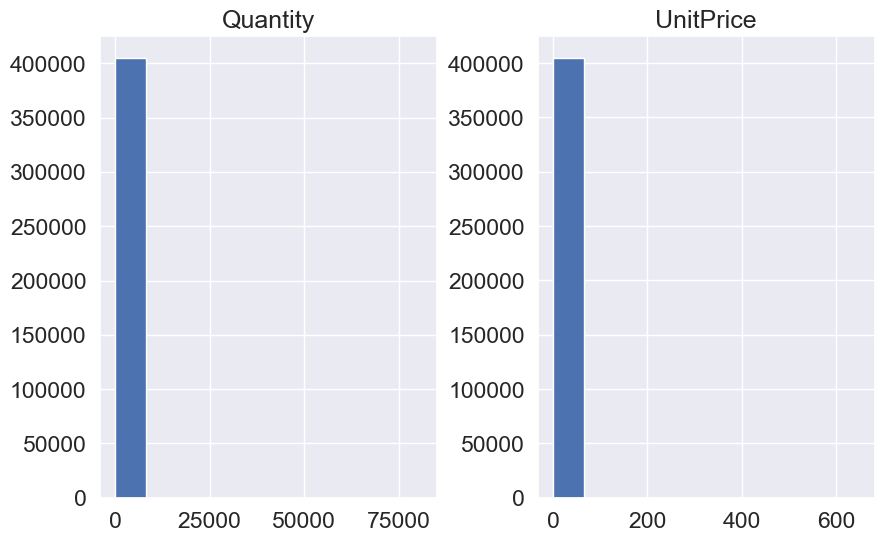

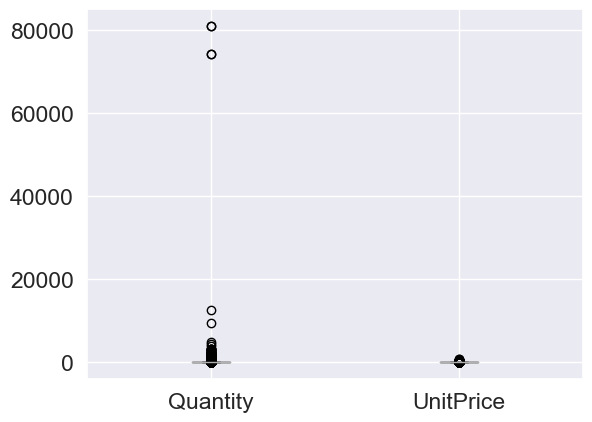

In [15]:
df.hist(bins = 10, figsize = (10,6))
plt.show()
df.boxplot()
plt.show()
#These shows that there are ouliers in the Quantity and UnitPrice columns

These shows there are ouliers in the Quantity and UnitPrice column, as majority of the Quantity are well below 200, while UnitPrice are below 500. To verify, I used value_counts then sort by values.

Quantity: I will setting my cap for quantity to 150, because the transaction quantity that are greater than 150 are just 2730 that is an average of 10 transaction perday for a company that does over 1000 transactions per day. Transcation above 150 are once in a blue moon transaction. Moreso, some of those transactions appear both as processed as cancelled. Which probably means the customers ordered them in error

UnitPrice: There are only 14 transactions with a unit price greater than 200, out of this 14, 4 of them were cancelled transaction which also appear as processed.

Overall, it is pretty safe to say dropping an outlier of about 2744 from a row of over 400000 should not affect our analysis

In [16]:
#to slice out only rows with quantity value of 150
df150 = df[df.Quantity > 150]
df = df[~df['Quantity'].isin(df150['Quantity'])]

#to slice out only rows with UnitPrice value of 200
dfu200 = df[df.UnitPrice > 200]
df = df[~df['UnitPrice'].isin(dfu200['UnitPrice'])]

In [17]:
# to slice the cancelled and processed transactions from the main data
df.reset_index(inplace = True)
df.reset_index(inplace = True)
df_can = df[df['Status'] == 'Cancelled']
df_pro = df[df['Status'] == 'Processed']

cancelled = len(df_can.index)
Processed = len(df_pro.index)
print(f'There are {cancelled} total cancelled transactions in the analyzed data')
print(f'There are {Processed} total processed transactions in the analyzed data')

#Merging both processed and cancelled transaction to slice out matched data
col_to_match = ['StockCode', 'Description', 'Quantity','UnitPrice','CustomerID', 'Country']
merged_data = pd.merge(df_pro, df_can, how = 'outer', indicator = True, on = col_to_match)

#slicing out the _merged data using the _merge column
matched_data = merged_data[merged_data['_merge'] == 'both']

#setting the index of matched_data to match the index in the main data table
matched_data = matched_data.copy()
matched_data.loc[:,'index_x'] = matched_data['index_x'].astype(int)
matched_data.set_index('index_x', inplace = True)

df1 = df[~df.index.isin(matched_data.index)]
df1 = df1.copy()
df1.drop(labels = 'index', axis = 1, inplace = True)
df1.head()

There are 8441 total cancelled transactions in the analyzed data
There are 393863 total processed transactions in the analyzed data


,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Status
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,United Kingdom,Processed
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,United Kingdom,Processed
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,United Kingdom,Processed
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,United Kingdom,Processed
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,United Kingdom,Processed


In [18]:
#inspecting the matched data
matched_data.head()

,InvoiceDate_x,InvoiceNo_x,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Status_x,index_y,InvoiceDate_y,InvoiceNo_y,Status_y,_merge
index_x,,,,,,,,,,,,,,
54,2010-12-01 09:02:00,536373,21071,VINTAGE BILLBOARD DRINK ME MUG,6.0,1.06,17850,United Kingdom,Processed,124260.0,2011-02-10 14:38:00,C543611,Cancelled,both
71,2010-12-01 09:32:00,536375,21071,VINTAGE BILLBOARD DRINK ME MUG,6.0,1.06,17850,United Kingdom,Processed,124260.0,2011-02-10 14:38:00,C543611,Cancelled,both
277,2010-12-01 10:51:00,536396,21071,VINTAGE BILLBOARD DRINK ME MUG,6.0,1.06,17850,United Kingdom,Processed,124260.0,2011-02-10 14:38:00,C543611,Cancelled,both
413,2010-12-01 11:33:00,536406,21071,VINTAGE BILLBOARD DRINK ME MUG,6.0,1.06,17850,United Kingdom,Processed,124260.0,2011-02-10 14:38:00,C543611,Cancelled,both
36566,2010-12-02 08:34:00,536602,21071,VINTAGE BILLBOARD DRINK ME MUG,6.0,1.06,17850,United Kingdom,Processed,124260.0,2011-02-10 14:38:00,C543611,Cancelled,both


For example: The first row has a same stockcode, Quantity, UnitPrice, Customer ID, Country but different status of Processed and Cancelled. That is an indication that is the same transaction, and it is counting/reading twice(i.e in the Processed and Cancelled transaction). I could have used drop duplicate using col_to_match as subset. This would have dropped geninue transactions as it is possible for a customer to order tha same products with the same quantity on different dates and also possible for a customer to order quite similar products on the same day.

## Checking for Duplicates

In [19]:
df1

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Status
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,United Kingdom,Processed
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,United Kingdom,Processed
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,United Kingdom,Processed
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,United Kingdom,Processed
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,United Kingdom,Processed
...,...,...,...,...,...,...,...,...,...
402299,2011-10-30 14:44:00,573388,22746,POPPY'S PLAYHOUSE LIVINGROOM,12.0,2.10,14895,United Kingdom,Processed
402300,2011-10-30 14:44:00,573388,22748,POPPY'S PLAYHOUSE KITCHEN,12.0,2.10,14895,United Kingdom,Processed
402301,2011-10-30 14:44:00,573388,22745,POPPY'S PLAYHOUSE BEDROOM,12.0,2.10,14895,United Kingdom,Processed
402302,2011-10-30 14:44:00,573388,22747,POPPY'S PLAYHOUSE BATHROOM,12.0,2.10,14895,United Kingdom,Processed


In [20]:
df1.drop_duplicates(keep = 'first', inplace = True)

In [21]:
df1

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Status
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,United Kingdom,Processed
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,United Kingdom,Processed
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,United Kingdom,Processed
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,United Kingdom,Processed
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,United Kingdom,Processed
...,...,...,...,...,...,...,...,...,...
402299,2011-10-30 14:44:00,573388,22746,POPPY'S PLAYHOUSE LIVINGROOM,12.0,2.10,14895,United Kingdom,Processed
402300,2011-10-30 14:44:00,573388,22748,POPPY'S PLAYHOUSE KITCHEN,12.0,2.10,14895,United Kingdom,Processed
402301,2011-10-30 14:44:00,573388,22745,POPPY'S PLAYHOUSE BEDROOM,12.0,2.10,14895,United Kingdom,Processed
402302,2011-10-30 14:44:00,573388,22747,POPPY'S PLAYHOUSE BATHROOM,12.0,2.10,14895,United Kingdom,Processed


## Dealing with Description with UnitPrice of Zero
Some rows are in the df with a UnitPrice of Zero. To deal with this I replace them with the group_mean UnitPrice of those products since those products has been sold in another rows/entity with a price. the zero is probably entered in error e.g PLASTERS IN TIN SKULLS is sold for £1.65 but appears as 0.00 in some entries

In [22]:
df1[df1.UnitPrice == 0].head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Status
32984,2011-04-04 14:42:00,548871,22162,HEART GARLAND RUSTIC PADDED,2.0,0.0,14410,United Kingdom,Processed
52181,2011-07-28 17:09:00,561669,22960,JAM MAKING SET WITH JARS,11.0,0.0,12507,Spain,Processed
62932,2011-04-14 18:57:00,550188,22636,CHILDS BREAKFAST SET CIRCUS PARADE,1.0,0.0,12457,Switzerland,Processed
87460,2010-12-21 13:45:00,539722,22423,REGENCY CAKESTAND 3 TIER,10.0,0.0,14911,EIRE,Processed
101060,2011-07-26 12:24:00,561284,22167,OVAL WALL MIRROR DIAMANTE,1.0,0.0,16818,United Kingdom,Processed


In [23]:
nau = df1.groupby('Description').UnitPrice.transform('mean')
df1.loc[df1.UnitPrice == 0, 'UnitPrice'] = nau

df1.reset_index(drop = True, inplace = True)

In [24]:
#creating a column revenue
df1.insert(7, column = 'Revenue', value = (df1['Quantity'].mul(df1['UnitPrice'])))

In [25]:
df1.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

In [26]:
f = df1[df1['InvoiceDate'] >= '2011-12-01']

In [27]:
##Dropping all transactions for December 2011, since we don't have the full month. and our data starts from 01-12-2010 
# so slicing from 01-12-2011 to 30-11-2011 that will make a complete year.
fut_df = df1[df1['InvoiceDate'] >= '2011-12-01']
df2 = df1[df1['InvoiceDate'] <= '2011-12-01']
data = df2.copy()
data.reset_index(inplace = True)
data.drop(labels = 'index', axis = 1, inplace = True)

In [28]:
data['Month'] = data['InvoiceDate'].dt.month_name()
data['Day_of_week'] = data['InvoiceDate'].dt.day_name()

In [29]:
#Seperating the Cancelled and Processed transactions
data_c = data[data['Status'] == 'Cancelled']
data_p = data[data['Status'] == 'Processed']
cancelled = len(data_c.index)
Processed = len(data_p.index)
print(f'After wrangling, there are {cancelled} total cancelled transaction in the clean data')
print(f'After wrangling, There are {Processed} total cancelled transaction in the clean data')


After wrangling, there are 8065 total cancelled transaction in the clean data
After wrangling, There are 367055 total cancelled transaction in the clean data


In [30]:
data_c.reset_index(drop = True, inplace = True)
data_p.reset_index(drop = True, inplace = True)
data_can = data_c.copy() #cancelled transactions
data_pro = data_p.copy() #processed transactions

In [31]:
data.to_csv('data.csv', index = False)
data_can.to_csv('cancelled_sales.csv', index = False)
data_pro.to_csv('processed_sales.csv', index = False)

In [130]:
data_can = data_c.copy() #cancelled transactions
data_pro = data_p.copy() #processed transactions

## EXPLANATORY DATA ANALYSIS

Q1. Sales Volume trend by Status per month

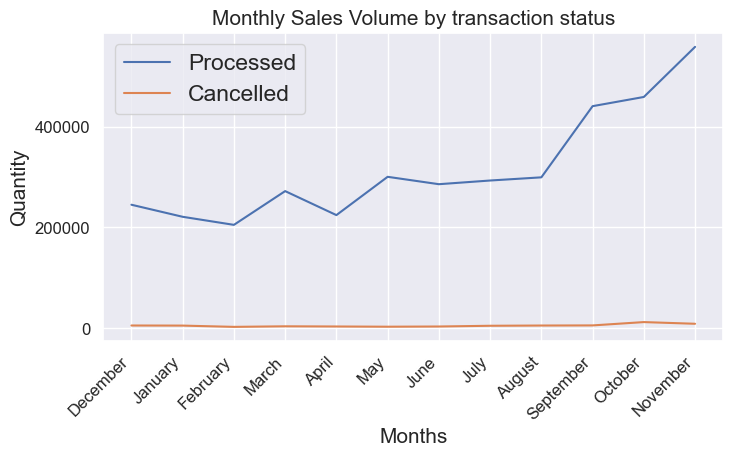

In [32]:
Sales_Volume_PM = data.groupby(['Month', 'Status']).Quantity.sum().unstack().reset_index()

#To order the months categorically, considering that our Analysis started from December of the previous year
sort_order = ['December', 'January','February','March','April','May','June','July','August','September','October','November',]

Sales_Volume_PM.index= pd.CategoricalIndex(Sales_Volume_PM['Month'], categories= sort_order, ordered= True )
Sales_Volume_PM = Sales_Volume_PM.sort_index()
Sales_Volume_PM = Sales_Volume_PM.reset_index(drop= True)
Sales_Volume_PM

plt.figure(figsize = (8,4))
sns.lineplot(data = Sales_Volume_PM, x = 'Month',y = 'Processed')
sns.lineplot(data = Sales_Volume_PM, x = 'Month',y = 'Cancelled')
plt.xticks(ticks = range(0, 12), labels = Sales_Volume_PM.Month, rotation=45, ha='right', fontsize = 12)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Quantity', fontsize = 15)
plt.yticks(fontsize = 12)
plt.title('Monthly Sales Volume by transaction status', fontsize = 15)
plt.legend(labels = ['Processed', 'Cancelled'])
plt.show()

## Observation:
November, October, September recorded the top 3 processed orders, this is no suprise as people tend to start preparing for Christmas, New year. Thereby, getting gifts for their families and loved ones. The lowest processed order was recorded in February, this seems quite unusual as February is a month for lovers to exchange gifts. However, the store might not really be dealing with love_gifts like flowers, wines etc. October, November, September recorded the top 3 cancelled orders.

## Top 10 countries by Revenue and Quantity ordered

          Country       Revenue   Quantity
0  United Kingdom  5.604201e+06  3135026.0
1            EIRE  1.955180e+05   101633.0
2         Germany  1.942789e+05   110050.0
3     Netherlands  1.853726e+05   113218.0
4          France  1.672606e+05    99476.0
          Country  Revenue  Quantity
0  United Kingdom      1.0       1.0
1            EIRE      2.0       4.0
2         Germany      3.0       3.0
3     Netherlands      4.0       2.0
4          France      5.0       5.0


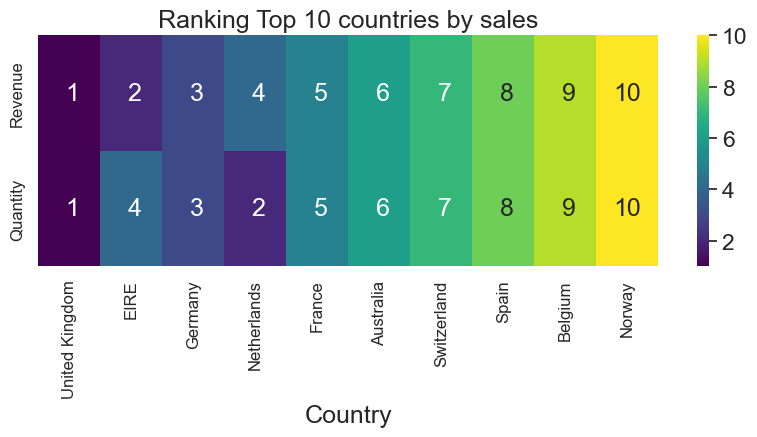

In [33]:
# top20 
revenue_country = data_pro.groupby(['Country']).agg({'Revenue':"sum", 'Quantity':'sum'}
                                                   ).sort_values(by = ['Revenue'], ascending = False).head(10)
print(revenue_country.head(5).reset_index())

revenue_country = revenue_country.rank(ascending = False, method = "average")
print (revenue_country.head(5).reset_index())

plt.figure(figsize = (10,3))
sns.heatmap(revenue_country.T, annot = True, fmt = "2.0f", cmap = "viridis")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Ranking Top 10 countries by sales")
plt.show()

## Observation: 
UK, EIRE, and Germany occupies the top 3 position in terms of revenue for the company while UK, Netherlands, Germany oredered the most product for the year in Review. It is no suprise that UK ranks 1st in both categories as the company is based in the United Kingdom.

## Q3: Top 20 Revenue generating products.

The top 20 products account for 10.74% of the company annual revenue


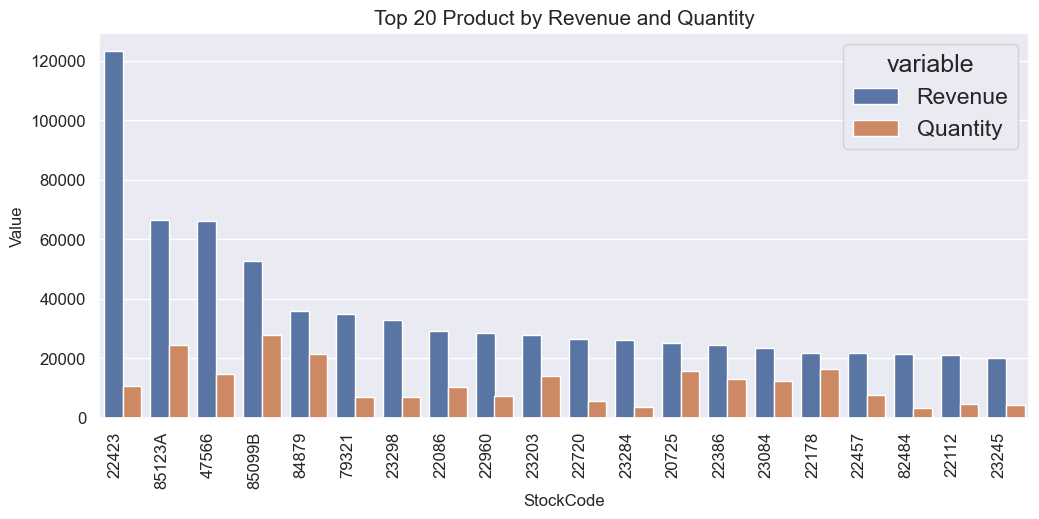

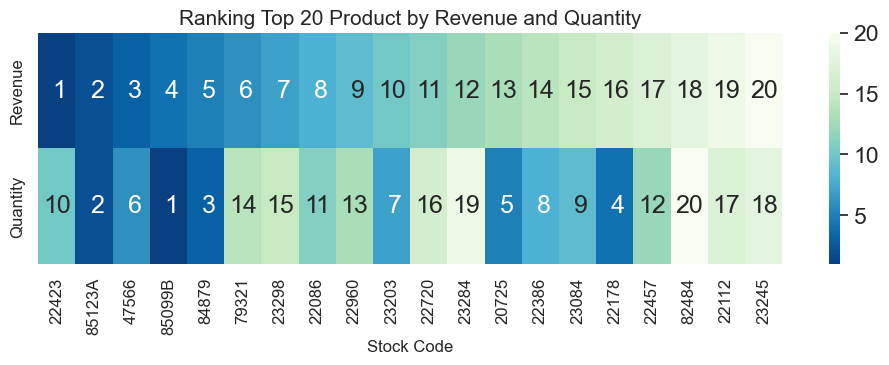

In [34]:
#calculating products per Revenue and Quantity
PPRQ = data_pro.groupby(['StockCode']).agg({'Revenue':"sum", 'Quantity':'sum'}
                                          ).sort_values(by = 'Revenue', ascending = False).head(20)
PPRQC = PPRQ.copy()
na = ((PPRQ.Revenue.sum()/data_pro.Revenue.sum()) * 100).round(2)
print(f'The top 20 products account for {na}% of the company annual revenue')

PPRQ.reset_index(inplace = True)
melted_data = pd.melt(PPRQ, id_vars=['StockCode'], var_name='variable', value_name='value')

# plot the bar chart
plt.figure(figsize = (12,5))
sns.barplot(x='StockCode', y='value', hue='variable', data=melted_data, dodge=True)

# set the title and axes labels
plt.title('Top 20 Product by Revenue and Quantity', fontsize = 15)
plt.xlabel('StockCode', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.xticks(rotation=90, ha='right', fontsize = 12)
plt.yticks(fontsize = 12)

# show the plot
plt.show()

#heatmap

PPRQ_r = PPRQC.rank(ascending = False, method = "average")
PPRQ_r.head(5)

plt.figure(figsize = (12,3))
sns.heatmap(PPRQ_r.T, annot = True, fmt = "2.0f", cmap = "GnBu_r")
plt.title("Ranking Top 20 Product by Revenue and Quantity", fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Stock Code', fontsize = 12)
plt.show()

## Observation: 
The product with Stockcode (22423 - REGENCY CAKESTAND 3 TIER) generated the highest revenue OF £122898 for the company in the one year period analysed while JUMBO BAG RED RETROSPOT with a StockCode of 85099B was the most ordered product of the year. The top 3 product per Revenue are 22423, 47556, and 85123A respectively while the top 3 products per quantity ordered are 85099B (Jumbo Bag Red Retrospot), 85123A(Hanging Light T-Light Holder) and 84879(Assorted Colour Bird Ornament) .

## Days of the week with the highest product order

<Figure size 1000x500 with 0 Axes>

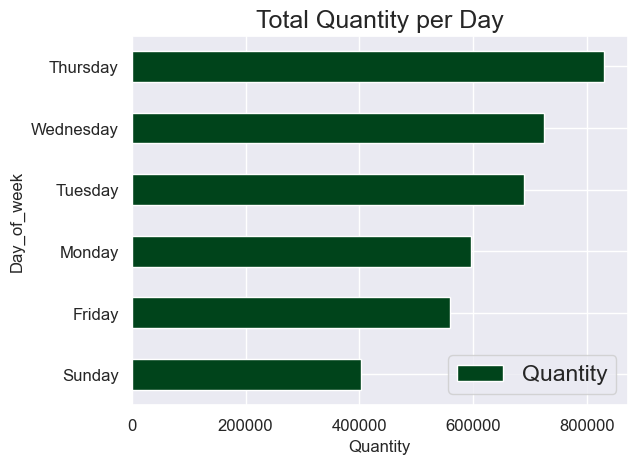

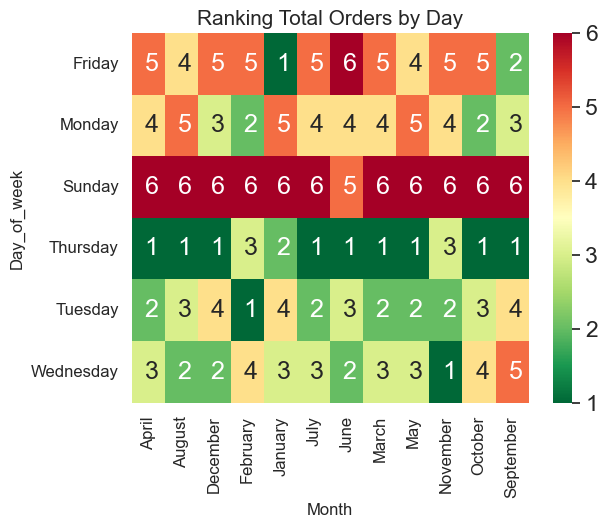

In [35]:
Days = data_pro.groupby('Day_of_week').Quantity.sum().to_frame().sort_values(by = 'Quantity')
plt.figure(figsize = (10,5))
Days.plot(kind = 'barh', colormap = 'BuGn_r')
plt.xlabel('Quantity', fontsize = 12)
plt.ylabel('Day_of_week', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Total Quantity per Day')
plt.show()

#heatmap
Days_r = data_pro.groupby(['Day_of_week', 'Month']).Quantity.sum().unstack()
Days_r = Days_r.rank(ascending = False, method = "average")
Days_r

sns.heatmap(Days_r, annot = True, fmt = "2.0f", cmap = "RdYlGn_r")
plt.title("Ranking Total Orders by Day", fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Day_of_week', fontsize = 12)
plt.show()


## Observation: 
Thursday seems to be the most busy day of the week totalling over 80,000 orders for the year. As a confirmation, it is also shown in the heatmap that Thursday ranks 1st in 9 months of 12 month periods analyzed.

## Exporting the clean data back to MS SQL

In [57]:
# Establish a connection to the SQL database
conn = pyodbc.connect(r'Driver={ODBC Driver 17 for SQL Server};Server=DESKTOP-CKGNKQL\SQLEXPRESS;Database=practice;Trusted_Connection=yes;')

# Create a cursor object
cursor = conn.cursor()

# Define the SQL query to create the table
create_table_query = """
CREATE TABLE clean_data (
    InvoiceDate datetime,
    InvoiceNo nvarchar(255),
    StockCode nvarchar(255),
    Description nvarchar(255),
    Quantity float,
    UnitPrice float,
    CustomerID nvarchar(255),
    Revenue float,
    Country nvarchar(255),
    Status nvarchar(255),
    [Month] nvarchar(255),
    Day_of_week nvarchar(255)
)
"""

# Execute the create table query
cursor.execute(create_table_query)

# Commit the changes to the SQL database
conn.commit()

# Close the connection
cursor.close()
conn.close()

In [53]:
# Establish a connection to the SQL database
conn = pyodbc.connect(r'Driver={ODBC Driver 17 for SQL Server};Server=DESKTOP-CKGNKQL\SQLEXPRESS;Database=practice;Trusted_Connection=yes;')

# Create a cursor object
cursor = conn.cursor()

# Define the insert query
insert_query = "INSERT INTO clean_data (InvoiceDate, InvoiceNo, StockCode, Description, Quantity, UnitPrice, CustomerID\
, Revenue, Country, Status, Month, Day_of_week) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"

# Extract the data from the DataFrame as a list of tuples
data = [tuple(row) for row in data_pro.values]

# Execute the insert query with the data
cursor.executemany(insert_query, data)

# Commit the changes to the SQL database
conn.commit()

# Close the connection
cursor.close()
conn.close()


In [73]:
# Establish a connection to the SQL database
conn = pyodbc.connect(r'Driver={ODBC Driver 17 for SQL Server};Server=DESKTOP-CKGNKQL\SQLEXPRESS;Database=practice;Trusted_Connection=yes;')

# Create a cursor object
cursor = conn.cursor()

# Define the SQL query to create the table
create_table_query1 = """
CREATE TABLE clean_retail_data (
    InvoiceDate datetime,
    InvoiceNo nvarchar(255),
    StockCode nvarchar(255),
    Description nvarchar(255),
    Quantity float,
    UnitPrice float,
    CustomerID nvarchar(255),
    Revenue float,
    Country nvarchar(255),
    Status nvarchar(255),
    [Month] nvarchar(255),
    Day_of_week nvarchar(255)
)
"""

# Execute the create table query
cursor.execute(create_table_query1)

# Define the insert query
insert_query1 = "INSERT INTO clean_retail_data (InvoiceDate, InvoiceNo, StockCode, Description, Quantity, UnitPrice, CustomerID\
, Revenue, Country, Status, Month, Day_of_week) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"

# Extract the data from the DataFrame as a list of tuples
data1 = [tuple(row) for row in data.values]


# Execute the insert query with the data
cursor.executemany(insert_query1, data1)


# Commit the changes to the SQL database
conn.commit()

# Close the connection
cursor.close()
conn.close()

In [72]:
data

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Revenue,Country,Status,Month,Day_of_week
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,15.30,United Kingdom,Processed,December,Wednesday
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,20.34,United Kingdom,Processed,December,Wednesday
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,22.00,United Kingdom,Processed,December,Wednesday
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,20.34,United Kingdom,Processed,December,Wednesday
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,20.34,United Kingdom,Processed,December,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
375115,2011-10-30 14:44:00,573388,22746,POPPY'S PLAYHOUSE LIVINGROOM,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday
375116,2011-10-30 14:44:00,573388,22748,POPPY'S PLAYHOUSE KITCHEN,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday
375117,2011-10-30 14:44:00,573388,22745,POPPY'S PLAYHOUSE BEDROOM,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday
375118,2011-10-30 14:44:00,573388,22747,POPPY'S PLAYHOUSE BATHROOM,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday


In [37]:
data_pro

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Revenue,Country,Status,Month,Day_of_week
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,17850,15.30,United Kingdom,Processed,December,Wednesday
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6.0,3.39,17850,20.34,United Kingdom,Processed,December,Wednesday
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,17850,22.00,United Kingdom,Processed,December,Wednesday
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,17850,20.34,United Kingdom,Processed,December,Wednesday
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,17850,20.34,United Kingdom,Processed,December,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
367050,2011-10-30 14:44:00,573388,22746,POPPY'S PLAYHOUSE LIVINGROOM,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday
367051,2011-10-30 14:44:00,573388,22748,POPPY'S PLAYHOUSE KITCHEN,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday
367052,2011-10-30 14:44:00,573388,22745,POPPY'S PLAYHOUSE BEDROOM,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday
367053,2011-10-30 14:44:00,573388,22747,POPPY'S PLAYHOUSE BATHROOM,12.0,2.10,14895,25.20,United Kingdom,Processed,October,Sunday


## DASHBOARD

Using Power BI, I built an interactive dashboard that gave a summary of the overall business performance, KPIs and generate insights that could help in improving the business.

Here is the link to the dashboard:
https://app.powerbi.com/view?r=eyJrIjoiNDFjMDFkMmMtNTJiNi00M2NlLTg0ZmYtMDNmMjI2NzZiY2I3IiwidCI6ImQwNDU3ZGRiLTJmYTUtNGM1Mi05YmUzLTJhMzIzYTAxZjRhMiJ9